In [23]:
!pip install datasets -q
!pip install lovely-tensors -q

In [24]:
import torch
import torch.nn as nn
import datasets
import transformers
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [25]:
import lovely_tensors as lt

lt.monkey_patch()

In [26]:
data = datasets.load_dataset("alkzar90/CC6204-Hackaton-Cub-Dataset")
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data, test_data = data["train"], data["test"]
train_data

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 5994
})

In [27]:
def match_random_sample():
    n = np.random.randint(0, len(train_data))
    print(n)
    print(train_data[n]["description"])
    train_data[n]["image"].show()
    print(train_data[n]["label"])


match_random_sample()

3535
the bird has a skinny tarsus that is pink as well as a small bill.
this bird has a short black bill, red feet, and a black throat.
a gray bird has a black beak and brown feathers with black spots.
the bird has a gray head and neck with a lighter gray body.
a medium sized bird with a bill that curves downwards, and brown wings
this bird has a whit belly with some shades of black on it's throat. it has brown wings with some black mixed in too. it has a small black beak.
this bird has wings that are brown and has a yellow belly
the bird has a black bill, and grey belly and breast.
this bird has wings that are brown and has a white belly
this bird has a brown crown, brown primaries, and a white belly.

117


In [28]:
from transformers import BertTokenizer, BertModel
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
image_model.classifier[-1] = nn.Linear(2048, 768)
image_model = image_model.to(device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_model = BertModel.from_pretrained("bert-base-uncased")
text_model = text_model.to(device)


embedding_sim = nn.CosineSimilarity()


def batch_image_embed(batch):
    input_data = processor(images=batch, return_tensors="pt")
    input_data = input_data.to(device)
    return image_model(**input_data).logits


def batch_text_embed(batch):
    encoded_input = tokenizer(batch, return_tensors="pt", padding=True)
    encoded_input = encoded_input.to(device)
    output = text_model(**encoded_input).last_hidden_state
    return output.mean(dim=1)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [29]:
img = train_data[0]['image']
text = train_data[0]['description']

img_e = batch_image_embed(img)
text_e = batch_text_embed(text)

img_e.shape, text_e.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

In [30]:
#freeze BERT and ResNet parameters

for param in image_model.parameters():
    param.requires_grad = False

for param in text_model.parameters():
    param.requires_grad = False

In [31]:
#randK quantization
def quantize_vector(vector, K):
    # vector shape = (batch_size, N)
    to_zero = vector.shape[1] - K
    indices = torch.randperm(vector.shape[1])[:to_zero]
    vector[:,indices] = 0
    return vector

In [32]:
class LinearModel(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.linear1 = nn.Linear(768, 200) # d -> num_classes
        self.linear2 = nn.Linear(768, 200) # d -> num_classes
        self.K = K
        self.prev_grad1 = None
        self.prev_grad2 = None

    def forward(self, images, texts):
        img_e = batch_image_embed(images)
        text_e = batch_text_embed(texts)
        x1 = self.linear1(img_e)
        x2 = self.linear2(text_e)
        x = x1 + x2
        return x

In [33]:
def convert_img(elem):
    return elem['image'].mode == "RGB"


train_data = train_data.shuffle()
train_data = train_data.filter(convert_img, num_proc=16)

ids = np.array(range(len(test_data)))
rand_ids = np.random.choice(ids, size=1000, replace=False)
val_data = test_data.select(rand_ids)
val_data = val_data.filter(convert_img, num_proc=16)
val_data

Filter (num_proc=16):   0%|          | 0/5994 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 1000
})

In [34]:
def validate(model):
    loss_hist = []
    true_preds = 0
    sum_loss = 0
    processed_samples = 0
    progress = tqdm(range(0, len(val_data) - batch_size, batch_size))
    with torch.no_grad():
        for j in progress:
            batch = val_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
    print(f"Mean val Loss: {sum_loss / (processed_samples / batch_size)}")
    print(f"Val accuracy: {true_preds / processed_samples}")
    print(processed_samples)

In [35]:
def train(model):
    p = 0.05 # constant for cummulative step
    loss_hist = []
    for i in range(epoch_num):
        print('EPOCH: ', i+1)
        true_preds = 0
        sum_loss = 0
        processed_samples = 0
        progress = tqdm(range(0, len(train_data) - batch_size, batch_size))
        lin_model.train()
        for j in progress:
            random = np.random.rand()
            ck = 1 if random < p else 0
            if model.prev_grad1 is None:
                ck = 1
            if ck == 1:
                optimizer.zero_grad()

            batch = train_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = model(images, texts)
            loss = loss_fun(output, labels)
            loss.backward()
            if ck == 0:
                model.linear1.weight.grad = quantize_vector(model.linear1.weight.grad, model.K)
                model.linear2.weight.grad = quantize_vector(model.linear2.weight.grad, model.K)
                model.linear1.weight.grad += model.prev_grad1
                model.linear2.weight.grad += model.prev_grad2

            model.prev_grad1 = model.linear1.weight.grad
            model.prev_grad2 = model.linear2.weight.grad
            optimizer.step()

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
        print(f"Mean epoch Loss: {sum_loss / (processed_samples / batch_size)}")
        print(f"Epoch accuracy: {true_preds / processed_samples}")
        # validate(model)
        print('='*75)
    return loss_hist

In [36]:
hists = []
ks = [50, 100, 500, 768]
# ks = [500, 100]

for k in ks:
    lin_model = LinearModel(k).to(device)
    loss_fun = nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.AdamW(lin_model.parameters(), lr)
    epoch_num = 3
    batch_size = 16
    loss_hist = train(lin_model)
    hists.append(loss_hist)
    torch.cuda.empty_cache()

EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.434688320771896
Epoch accuracy: 0.017881016042780747
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.8418172068774386
Epoch accuracy: 0.07169117647058823
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.4358589515329045
Epoch accuracy: 0.14705882352941177
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.253636469815504
Epoch accuracy: 0.0427807486631016
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.590556092440763
Epoch accuracy: 0.15775401069518716
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.122370617274932
Epoch accuracy: 0.24782754010695188
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 5.089524733191506
Epoch accuracy: 0.05080213903743316
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.399389125446585
Epoch accuracy: 0.20421122994652408
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 4.035959700849604
Epoch accuracy: 0.31600935828877
EPOCH:  1


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 13.976050848629386
Epoch accuracy: 0.018549465240641713
EPOCH:  2


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 18.463710888184327
Epoch accuracy: 0.02356283422459893
EPOCH:  3


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 18.230931093348538
Epoch accuracy: 0.03375668449197861


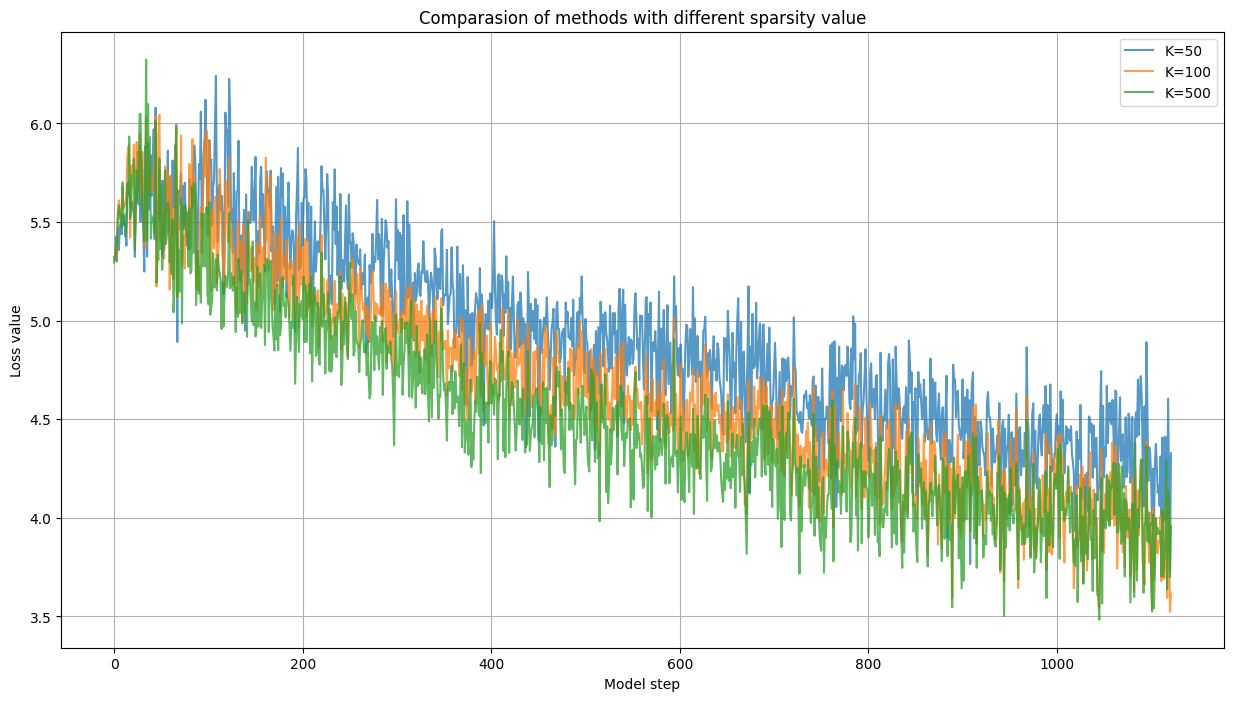

In [38]:
import matplotlib.pyplot as plt
# Smoothing function using a moving average
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Define the window size for the moving average
window_size = 10

# Smooth the loss data using the moving average


plt.figure(figsize=(15, 8))
for i, loss_hist in enumerate(hists[:-1]):
    label = f"K={ks[i]}"
    plt.plot(loss_hist, alpha=0.75, label=label)
plt.grid()
plt.title('Comparasion of methods with different sparsity value')
plt.xlabel('Model step')
plt.ylabel('Loss value')
plt.legend()
plt.show()

In [39]:
np.save('res.npy', hists)